# Reeb Graph Matching
#### Implementing 'Topology Matching for Fully Automatic Similarity Estimation of 3D Shapes'
#### http://graphics.stanford.edu/courses/cs468-08-fall/pdf/Hilaga01.pdf
#### (Hilaga et al., 2001)

In [8]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
import reeb_matching
from copy import deepcopy
sns.set()


Load tree data

In [9]:
prefix = 'input_strength032320'
node_points, node_connectivity, node_color = csd_functions.load_tree(prefix)

Compute multiresoluion reeb graph

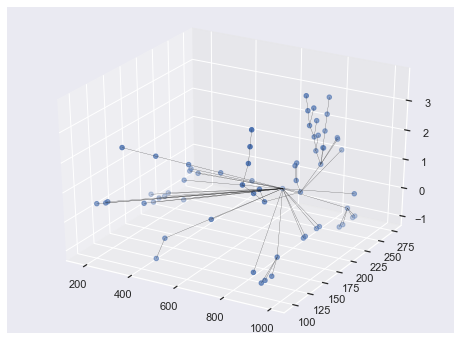

In [10]:
G = nx.Graph()
G.add_edges_from(node_connectivity)

node_attributes = {node_id : {'Position' : node_points[node_id,:], 'Visited' : 0, 'Merged':[],'Inserted':[],'New_Merge':[]} for node_id in list(G.nodes)}
nx.set_node_attributes(G,node_attributes)

interval_dict = reeb_matching.compute_intervals(node_points, 10)
reeb_matching.graph_search(G, 592, interval_dict,0)
reeb_matching.plot_graph(G)

G.clear()

Build attribute dictionary for MRG

In [11]:
#Load tree into graph
G = reeb_matching.make_graph(node_points,node_connectivity)
A = reeb_matching.make_graph(node_points,node_connectivity)


resolution_list = [16,8,4,2]
att_dict = reeb_matching.MRG_attributes(G, resolution_list)



In [12]:
print(att_dict)


{0: {'Node_Count': 23.0, 'Resolution': 2, 'Merge_List': {1334: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1335: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1339: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1340: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1341: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1342: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1343: {'Node_Count': 3, 'Resolution': 4, 'Merge_List': {1345: {'Node_Count': 2, 'Resolution': 8, 'Merge_List': {1346: {'Node_Count': 1, 'Resolution': 16, 'Merge_List': {}}}}}}, 1351: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1352: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1353: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1354: {'Node_Count': 1.0, 'Resolution': 4, 'Merge_List': {}}, 1355: {'Node_Count': 9, 'Resolution': 4, 'Merge_List': {1356: {'Node_Count': 2, 'Resolution': 8, 'Merge_List': {553: {'Node_Count': 1, 'Resolution

In [13]:
print(att_dict[0]['Merge_List'].keys())
print(att_dict[0]['Node_Count'])

children = reeb_matching.unpack_node(att_dict[0])
print(children)

dict_keys([1334, 1335, 1339, 1340, 1341, 1342, 1343, 1351, 1352, 1353, 1354, 1355])
23.0
[1334, 1335, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1351, 1352, 1353, 1354, 1355, 1356, 553, 1362, 548, 1363, 1247, 1364, 1286, 1334, 1335, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1351, 1352, 1353, 1354, 1355, 1356, 553, 1362, 548, 1363, 1247, 1364, 1286]


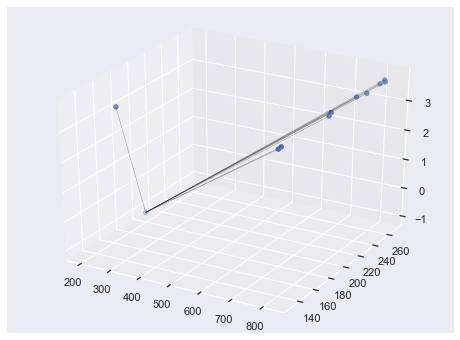

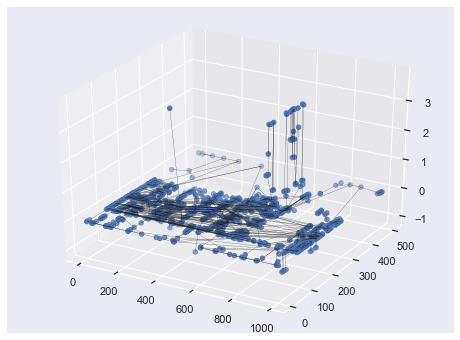

In [14]:
reeb_matching.plot_graph(G)
reeb_matching.plot_graph(A)